<a href="https://colab.research.google.com/github/comchem/Pytorch_DeepLearning_Tutorials/blob/master/Sec7-NLP_ANN/4-Text_Classification_RNN_with_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchtext.legacy.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
!git clone https://github.com/comchem/Pytorch_DeepLearning_Tutorials.git

Cloning into 'Pytorch_DeepLearning_Tutorials'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 204 (delta 98), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (204/204), 2.73 MiB | 12.42 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [3]:
path = './Pytorch_DeepLearning_Tutorials/data/spam.csv'
df = pd.read_csv(path, encoding='ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# rename columns to something better
df.columns = ['labels', 'data']

In [8]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})

In [10]:
df2 = df[['data', 'b_labels']]

In [11]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [12]:
df2.to_csv('spam2.csv', index=False)

In [13]:
TEXT = ttd.Field(
    sequential = True,
    batch_first = True,
    lower = True,
    # tokenize = 'spacy',
    pad_first = True
)
LABEL = ttd.Field(sequential = False, use_vocab = False, is_target = True)

# Note: if you don't specify use_vocab = False, then Pytorch will complain later when you try 
# to iterate over the dataset that the attribute 'vocab' doesn't exist.

# Note 2: if you don't specify is_target = True, then Pytorch will assume it's part of the input,
# so when you iterate over the dataset it will be like:
# for (inputs, targets), _ in iterator:
# where the 2nd element (_) should have been the target.

dataset = ttd.TabularDataset(
    path = 'spam2.csv',
    format = 'csv',
    skip_header = True,
    fields = [('data', TEXT), ('label', LABEL)]
)

In [14]:
train_dataset, test_dataset = dataset.split()  # default is 0.7

In [15]:
TEXT.build_vocab(train_dataset)

In [16]:
vocab = TEXT.vocab
type(vocab)

torchtext.vocab.Vocab

In [17]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), sort_key = lambda x: len(x.data),
    batch_sizes = (2,2), device = device
)

In [19]:
len(vocab)

10978

In [20]:
### Define the model
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim    # Pretrained vectors
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
          input_size = self.D,
          hidden_size = self.M,
          num_layers = self.L,
          batch_first = True)
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # embedding layer --> N x T --> N x T x D
        # turns word indexes into word vectors
        out = self.embed(X)

        # get RNN unit output --> N x T x D --> N x T x M
        out, _ = self.rnn(out, (h0, c0))

        # max pool --> N x T x M --> N x M
        out, _ = torch.max(out, 1)
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out)
        return out

In [21]:
# Instantiate the model
model = RNN(n_vocab = len(vocab), embed_dim = 20, n_hidden=15, n_rnnlayers = 1, n_outputs = 1)
model.to(device)

RNN(
  (embed): Embedding(10978, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

In [31]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_iter:
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      # move data to GPU  
      # inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      
    # Get train loss and test loss
    train_loss = np.mean(train_loss)   # a little misleading

    test_loss = []
    for inputs, targets in test_iter:
      #inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1,1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0      
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [32]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 15
)

Epoch 1/15, Train Loss: 0.0143, Test Loss: 0.1996, Duration: 0:00:05.734223
Epoch 2/15, Train Loss: 0.0086, Test Loss: 0.2311, Duration: 0:00:05.640662
Epoch 3/15, Train Loss: 0.0114, Test Loss: 0.2290, Duration: 0:00:05.700237
Epoch 4/15, Train Loss: 0.0062, Test Loss: 0.3013, Duration: 0:00:05.659960
Epoch 5/15, Train Loss: 0.0084, Test Loss: 0.2757, Duration: 0:00:05.610822
Epoch 6/15, Train Loss: 0.0111, Test Loss: 0.3922, Duration: 0:00:05.584282
Epoch 7/15, Train Loss: 0.0123, Test Loss: 0.4142, Duration: 0:00:05.659254
Epoch 8/15, Train Loss: 0.0126, Test Loss: 0.3464, Duration: 0:00:05.579321
Epoch 9/15, Train Loss: 0.0108, Test Loss: 0.3667, Duration: 0:00:05.585105
Epoch 10/15, Train Loss: 0.0085, Test Loss: 0.3987, Duration: 0:00:05.651628
Epoch 11/15, Train Loss: 0.0058, Test Loss: 0.3362, Duration: 0:00:05.624408
Epoch 12/15, Train Loss: 0.0188, Test Loss: 0.3559, Duration: 0:00:05.614554
Epoch 13/15, Train Loss: 0.0056, Test Loss: 0.2951, Duration: 0:00:05.675321
Epoch 14

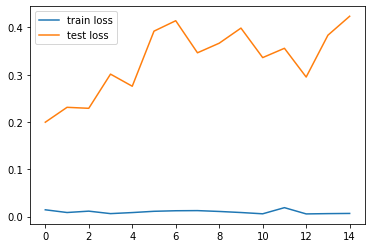

In [33]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [35]:
# Accuracy

p_train = []
y_train = []
for inputs, targets in train_iter:
    targets = targets.view(-1, 1).float()
    
    # Forward pass
    outputs = model(inputs)
    #print(outputs.shape)
    
    # Get prediction
    predictions = list((outputs > 0).cpu.numpy())
    
    # Store prediction
    p_train += predictions   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    y_train += list(targets.cpu.numpy())
    
p_train = np.array(p_train)
y_train = np.array(y_train)
train_acc = np.mean(y_train == p_train)


p_test = []
y_test = []
for inputs, targets in test_iter:
    targets = targets.view(-1, 1).float()

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    predictions = list((outputs > 0).cpu.numpy())
    
    # update counts
    p_test += predictions    # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    y_test += list(targets.cpu.numpy())
    
p_test = np.array(p_test)
y_test = np.array(y_test)
test_acc = np.mean(y_test == p_test)

print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

AttributeError: ignored

In [45]:
p_train = []
y_train = []
for inputs, targets in train_iter:
    targets = targets.view(-1, 1).float()
    
    # Forward pass
    outputs = model(inputs)
   
    # Get prediction
    outputs.cpu()

In [27]:
df[df['labels'] == 'spam'].size / df.size

0.13406317300789664

In [28]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = dm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)    # color 부여
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [29]:
cm = confusion_matrix(y_test, p_test)

NameError: ignored